# Laboratorio II -  Series Temporales

Basado en *Tutorial03 Holt Winters Smoothing.ipynb* @ https://github.com/DiploDatos/AnalisisSeriesTemporales

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

## Data: Demanda

"Los datos fueron extraidos desde http://portalweb.cammesa.com/memnet1/Pages/descargas.aspx "

Al parecer se corresponde con la demanda de potencia de:
- Usuarios Domesticos (Residencial)
- Comercios
- Industrias y grandes comercios

In [3]:
# Leemos los datos sin ninguna configuración particular para ver el formato
data = pd.read_csv('datasets/demanda.csv')
data.head(14)

,TIPO,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
0,1/1/2015,5.096.406,3.362.160,3.247.624,11.706.190
1,1/2/2015,4.438.153,3.076.341,3.150.592,10.665.087
2,1/3/2015,4.823.968,3.263.679,3.460.880,11.548.527
3,1/4/2015,3.756.853,2.962.997,3.306.585,10.026.435
4,1/5/2015,4.224.673,2.979.187,3.263.774,10.467.634
5,1/6/2015,4.941.276,3.090.851,3.222.293,11.254.420
6,1/7/2015,5.513.161,3.167.257,3.226.944,11.907.362
7,1/8/2015,4.797.705,3.107.591,3.224.967,11.130.263
8,1/9/2015,4.350.514,2.974.028,3.228.362,10.552.903
9,1/10/2015,4.362.417,3.011.162,3.348.595,10.722.174


Vemos los datos:
- TIPO es del tipo fecha y de intervalo mensual y el primer número corresponde al dia (dayfirst=True)
- Los restantes son del tipo numérico con separadores de miles '.' (thousands='.')

In [4]:
# Leemos nuevamente los datos con la configuracion encontrada.
data = pd.read_csv('datasets/demanda.csv',index_col='TIPO',parse_dates=True, dayfirst=True,thousands='.')
# Renomabramos el Indice
data.index.names=['Month']
# Vemos el resultado de la lectura
data.head(14)

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
Month,,,,
2015-01-01,5096406,3362160,3247624,11706190
2015-02-01,4438153,3076341,3150592,10665087
2015-03-01,4823968,3263679,3460880,11548527
2015-04-01,3756853,2962997,3306585,10026435
2015-05-01,4224673,2979187,3263774,10467634
2015-06-01,4941276,3090851,3222293,11254420
2015-07-01,5513161,3167257,3226944,11907362
2015-08-01,4797705,3107591,3224967,11130263
2015-09-01,4350514,2974028,3228362,10552903


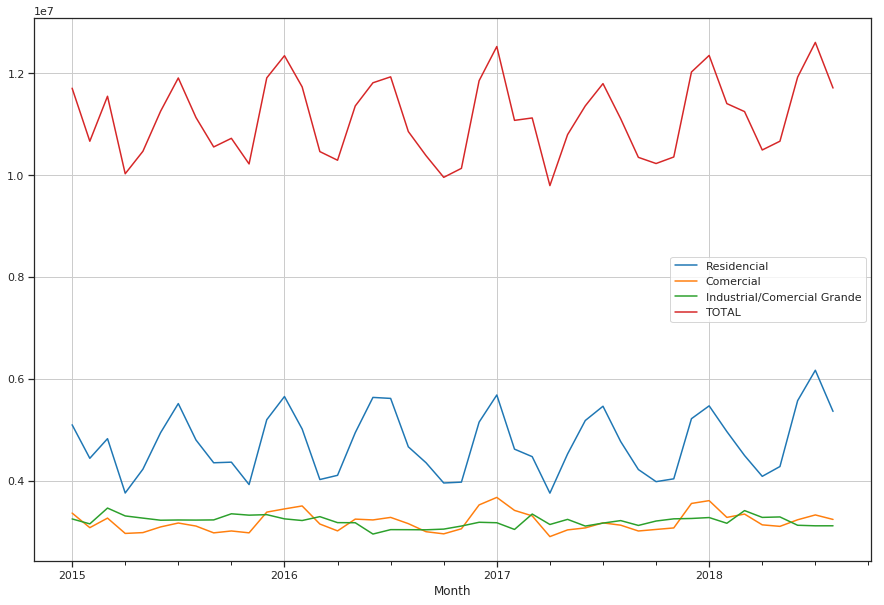

In [5]:
# Veamos plots para ver la pinta de las series
f, axs = plt.subplots(1,1,figsize=(15,10))
data.plot(ax=axs)
plt.grid(True)

In [6]:
#Vamos a trabajar con el TOTAL
y = data['TOTAL'].copy()
y.index = y.index.to_period(freq='M')
# Anotamos log(y) tambien
ylog = np.log(data['TOTAL'].copy())
ylog.index = ylog.index.to_period(freq='M')
#
ts = data['TOTAL']

In [7]:
data.describe().round(2)

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
count,44.00,44.00,44.00,44.00
mean,4745018.02,3193531.25,3201238.93,11139788.20
std,627095.26,193716.15,107030.91,764343.47
min,3754330.00,2900824.00,2950818.00,9793759.00
25%,4222957.00,3038991.25,3122472.25,10466094.50
50%,4715575.50,3151394.50,3215652.00,11126247.50
75%,5201443.25,3312377.75,3266523.25,11800556.25
max,6167114.00,3670275.00,3460880.00,12605842.00


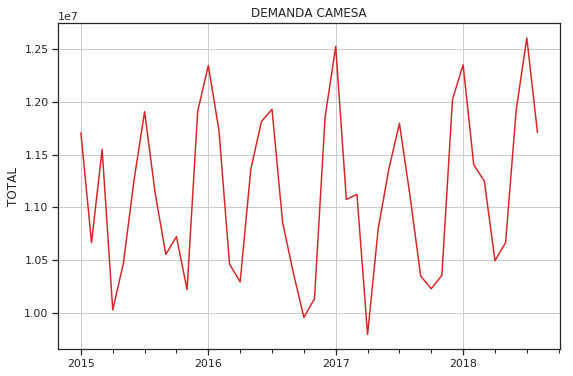

In [8]:
fig, ax= plt.subplots(figsize=(9,6))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('TOTAL')
ax.set_title('DEMANDA CAMESA')
ax.grid(True)
plt.show()

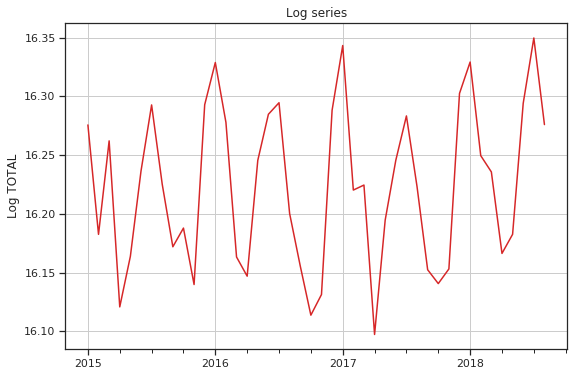

In [9]:
fig, ax= plt.subplots(figsize=(9,6))
ylog.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log TOTAL')
ax.set_title('Log series')
ax.grid(True)
plt.show()

## Time series decomposition

Utilizamos X-13 ARIMA-SEATS para la descomposicion de la serie temporal.

In [10]:
# x13 recibe Datetimeindex y PeriodIndex pero al usar plot_components_x13 from plotting crashea si no es DatetimeIndex 
decomposition = sm.tsa.x13_arima_analysis(y,x12path='.')

Utilizando <TT>dir</TT> revisamos lo generado por la instancia de *x_13_arima_analysis*

In [11]:
dir(decomposition)[-6:]

['observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

Aprovechamos el modulo <TT>plotting</TT> para graficar las componentes (introdujimos ciertas modificaciones para que acepte Datetime y PeriodIndex indistintamente) 

Datetime was generated for plotting based on PeriodIndex


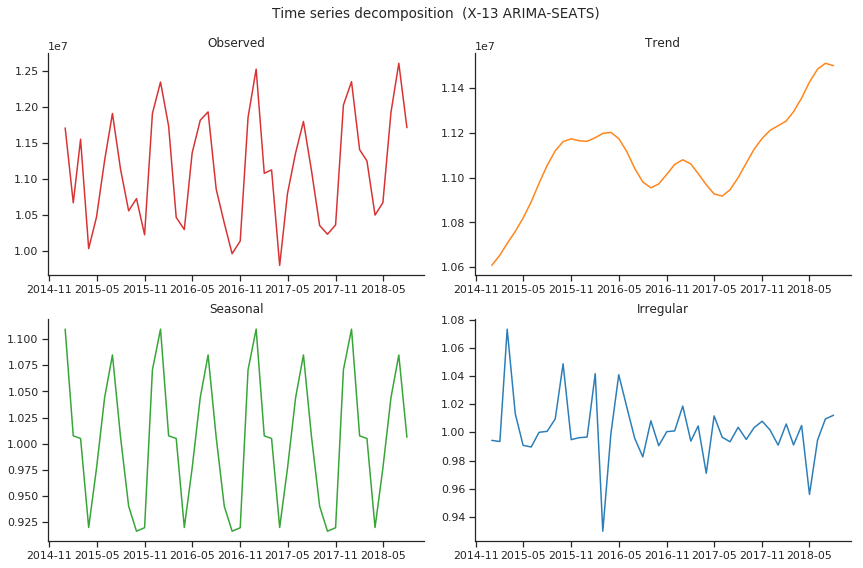

In [12]:
from plotting import plot_components_x13_mod
plot_components_x13_mod(decomposition)
plt.show()

Guardamos los resultados de X-13-ARIMA en texto.

In [13]:
f=open('x13results_lab2.txt', mode='w+')
f.write(decomposition.results)
f.close()

#### Descomposicion Basica

Veamos que pasaria si no tuvieramos X-13

In [14]:
basic_decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')

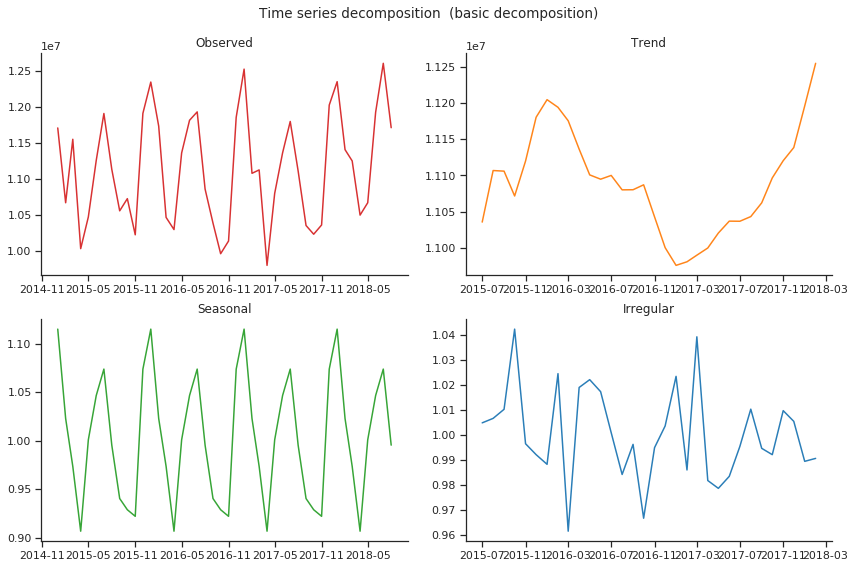

In [15]:
from plotting import plot_components_basic_decomp
plot_components_basic_decomp(basic_decomposition)
plt.show()

Vemos que las descomposiciones son similares (sobretodo para seasonal) y los valores son del orden.

## Trend corrected exponential smoothing

Veamos solo el metodo de Holt

In [16]:
ts=decomposition.seasadj
#ts.index=ts.index.to_period(freq='M')

In [17]:
model_sm = sm.tsa.Holt(ts).fit()
smoothed_sm = model_sm.fittedvalues
alpha_sm = model_sm.model.params['smoothing_level']
betha_sm = model_sm.model.params['smoothing_slope']
mse_sm = sm.tools.eval_measures.mse(ts,smoothed_sm)
print(' Smoothing parameter: alpha  {0:.4f}'.format(alpha_sm))
print(' Smoothing parameter: betha  {0:.5f}'.format(betha_sm))
print(' In-sample fit:')
print(' MSE               {0:.4f}'.format(mse_sm))

 Smoothing parameter: alpha  0.1793
 Smoothing parameter: betha  0.00000
 In-sample fit:
 MSE               85088544332.9198


Notemos que el parametro $\beta\sim0$ lo cual nos habla que no estamos corrigiendo por tendencia (filminas series temporales ~68).

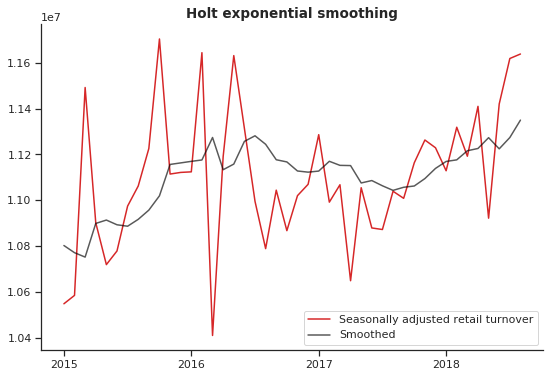

In [18]:
#smoothed=pd.Series(smoothed_sm, index=ts.index)
fig, ax= plt.subplots(figsize=(9,6))
ts['2015':].plot(color='#D62728', label='Seasonally adjusted retail turnover')
smoothed_sm['2015':].plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

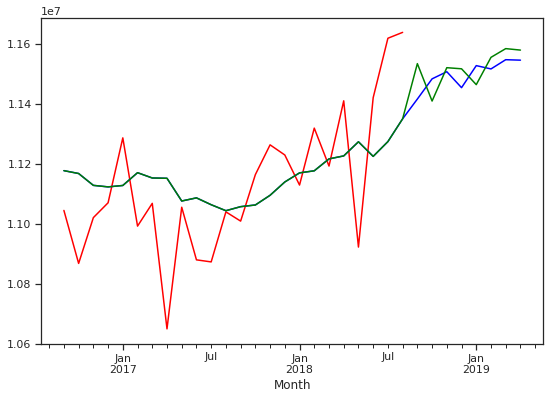

In [19]:
# Veamos algun forecast para la presente situacion
h=8
w=h*3
data = ts
model = sm.tsa.Holt
pred_index = data.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='red',figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='green');

## Holt-winters exponential smoothing

El análisis de X13 sugiere (@ x13results_lab2.txt):
- **AICC (with aicdiff=-2.00) prefers log transformation**
- **Multiplicative seasonal adjustment will be performed.**

In [20]:
def hw_summary(model_sm):
    alpha_sm = model_sm.model.params['smoothing_level']
    betha_sm = model_sm.model.params['smoothing_slope']
    delta_sm = model_sm.model.params['smoothing_seasonal']
    mse_sm = sm.tools.eval_measures.mse(model_sm.data.endog,model_sm.fittedvalues)
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' Smoothing parameter: alpha  {0:.4f}'.format(alpha_sm))
    print(' Smoothing parameter: betha  {0:.4f}'.format(betha_sm))
    print(' Smoothing parameter: delta  {0:.4f}'.format(delta_sm))
    print(' In-sample fit:')
    print(' MSE               {0:.4f}'.format(mse_sm))
    print(' RMSE               {0:.4f}'.format(rmse_sm))
    return rmse_sm

In [21]:
ahw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()

In [22]:
hw_summary(ahw_sm);

 Smoothing parameter: alpha  0.0526
 Smoothing parameter: betha  0.0526
 Smoothing parameter: delta  0.4211
 In-sample fit:
 MSE               152389189756.9879
 RMSE               390370.5800


In [23]:
mhw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm);

 Smoothing parameter: alpha  0.0526
 Smoothing parameter: betha  0.0526
 Smoothing parameter: delta  0.4211
 In-sample fit:
 MSE               123127465459.4417
 RMSE               350895.2343


In [24]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped);

 Smoothing parameter: alpha  0.0526
 Smoothing parameter: betha  0.0526
 Smoothing parameter: delta  0.4211
 In-sample fit:
 MSE               122864213089.0105
 RMSE               350519.9182


In [25]:
ahw_log_sm=sm.tsa.ExponentialSmoothing(ylog, trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
hw_summary(ahw_log_sm);

 Smoothing parameter: alpha  0.0526
 Smoothing parameter: betha  0.0526
 Smoothing parameter: delta  0.4211
 In-sample fit:
 MSE               0.0012
 RMSE               0.0352


Vemos que los parametros determinados por todas las configuraciones son identicos (al menos en las cifras significativas observadas). A partir de los mismos observamos que la variacion de la serie es mayoritariamente estacional.

En lo que sigue trabajamos con log(y)

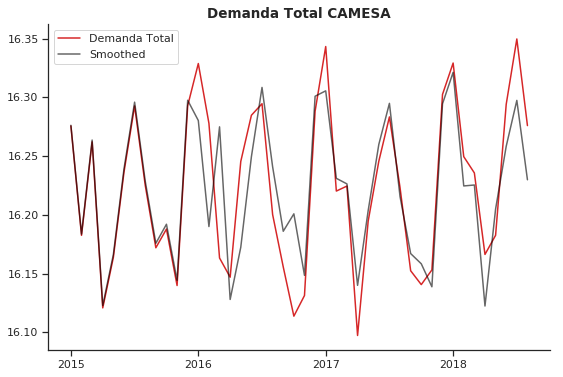

In [26]:
smoothed=pd.Series(ahw_log_sm.fittedvalues, index=y.index)

fig, ax= plt.subplots(figsize=(9,6))

ylog['2014':].plot(color='#D62728', label='Demanda Total')
smoothed['2014':].plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Demanda Total CAMESA', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Model diagnostics

Utiliamos el modelo multiplicativo de Holt-Winters model. Los residuos se mantienen acotados y la correlacion de ellos es muy pequeña. 

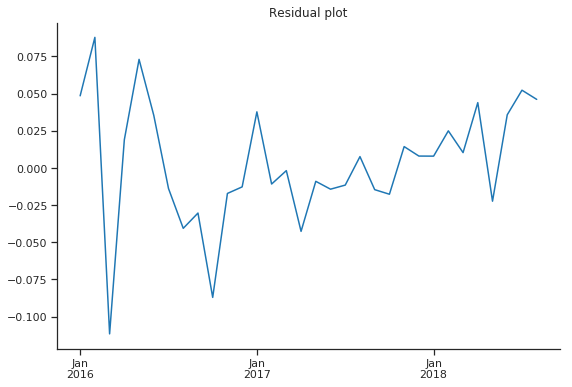

In [44]:
resid = (ylog-ahw_log_sm.fittedvalues)[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

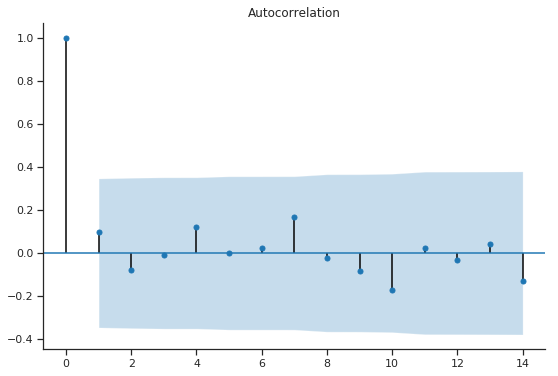

In [45]:
fig, ax = plt.subplots(figsize=(9,6))
sm.graphics.tsa.plot_acf(resid, lags=14, ax=ax)
sns.despine()
plt.show()

/home/felix/anaconda3/envs/series_temporales/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


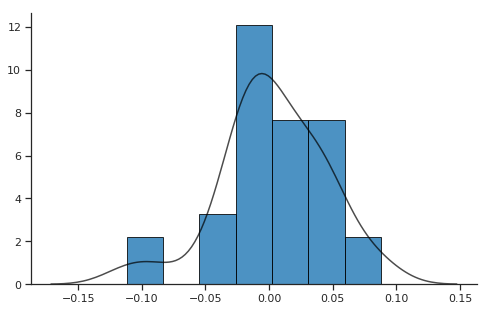

In [46]:
from plotting import histogram
histogram(resid)
plt.show()

La distribución de residuos parece un tanto asimétrica, es decir, que no parece provenir de una distribución normal, por lo que para la estimación de intervalos de confianza deberiamos utilizar algun metodo alternativo o utilizar el esquema *normal*, sabiendo de su posible **no** representatividad.

## Model validation

Los análisis anteriores parecen indicar cierta ventaja para el modelo de Holt-winters multiplicativo.

In [27]:
# Real time forecasting 

ts=ylog # log series for the log-additive model

validation=y['2017-04':].index
start = y.index.get_loc('2017-04') 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
pred4 = [] # log additive holt winters
pred5 = [] # log multiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(ts.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    resid = (ts.iloc[:i]-model.fittedvalues)[12:] # residuals
    y_pred = np.exp(model.forecast(1)[0])*np.mean(np.exp(resid)) # forecast with a retransformation adjustment 
    pred4.append(y_pred) # long additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(ts.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    resid = (ts.iloc[:i]-model.fittedvalues)[12:] # residuals
    y_pred = np.exp(model.forecast(1)[0])*np.mean(np.exp(resid)) # forecast with a retransformation adjustment 
    pred5.append(y_pred) # long additive holt winters forecast

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Log additive','Log multiplicative', 'Actual']
results = np.vstack([pred1,pred2,pred3,pred4,pred5,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [28]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(5):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,420325.448,100612.273
Additive,308142.137,75104.168
Multiplicative,315179.060,77158.418
Log additive,305187.593,71476.907
Log multiplicative,305093.159,71439.578


Vemos que los modelos *Log additive* y *Log multiplicative* son similares en cuanto a su nivel de error. En lo que sigue utilizamos el modelo multiplicativo.

## Forecast

Generamos un pronostico a h pasos

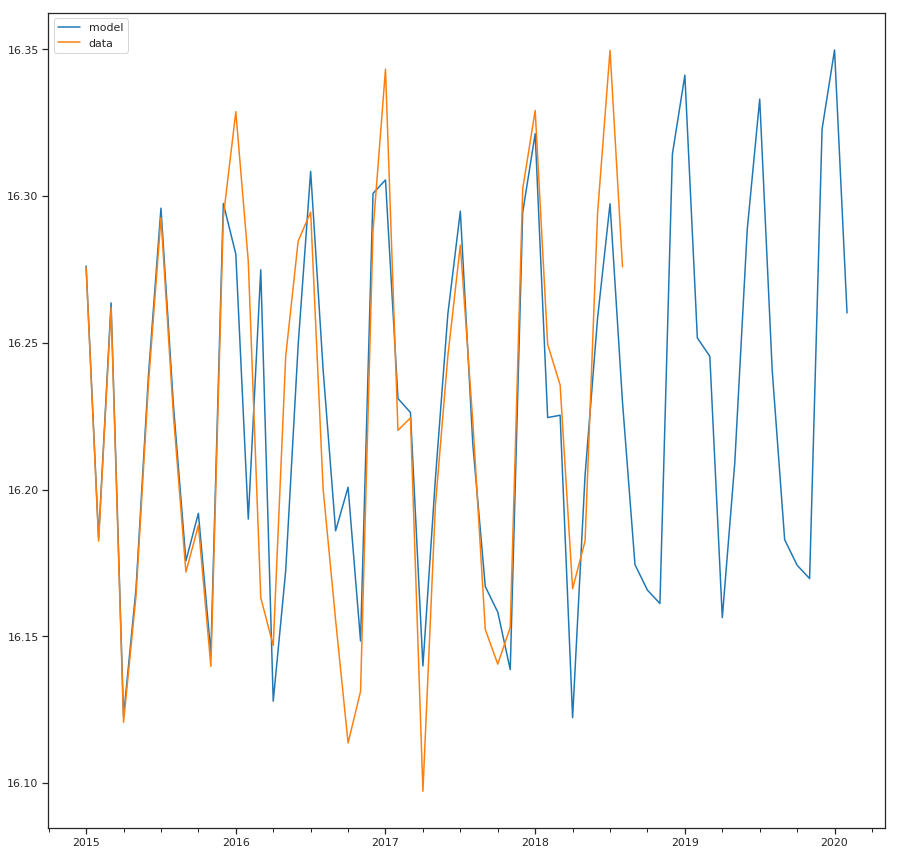

In [29]:
h=18

model = sm.tsa.ExponentialSmoothing(ylog, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()

forecast = model.forecast(h)

plot = pd.DataFrame()
plot['model'] = pd.concat([model.fittedvalues, forecast])
plot['data'] = ts
#
plot['2014':].plot(figsize=(15,15));

El pronostico generado parece correcto en forma funcional y en cuanto a los valores alcanzados (aunque no determinamos los margenes de confidencia).